# CAPM Data Project

First, we import the relevant packages, including the Yahoo Finance library, which allows us to fetch historical market data, and the API of Statsmodel, which is used for statistical modeling including regression models, time series analysis etc.

In [1]:
#%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2

#from dataproject import *

# 1 Data

## 1.1 Importing data

In this section, we import the monthly stock data from Yahoo Finance for Miscrosoft, Novo Nordisk and Tesla, ranging from December 2019 to April 2024. We only import the Adjusted Close, which is the closing stock price, adjusted for corporate actions such as dividend payments or stock splits.

Further, we calculate the monthly returns for the three stocks, cleaning the data with dropna() by removing the December 2019 rows which has missing data for percentage changes due to a lack of a preceding month's data.

In [2]:
# Importing monthly stock data from Yahoo Finance
data = yf.download(["MSFT", "NVO", "TSLA"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
data = data['Adj Close'] # Only look at the adjusted close stock price

# Calculate monthly returns
data["MSFT_returns"] = data["MSFT"].pct_change() * 100
data["NVO_returns"] = data["NVO"].pct_change() * 100
data["TSLA_returns"] = data["TSLA"].pct_change() * 100
data = data.dropna() # Drops 2019-12-01 which is NA

print(data.head())

[*********************100%%**********************]  3 of 3 completed

Ticker            MSFT        NVO       TSLA  MSFT_returns  NVO_returns  \
Date                                                                      
2020-01-01  163.737289  28.578428  43.371334      7.945465     5.096733   
2020-02-01  155.830841  27.309950  44.532665     -4.828740    -4.438587   
2020-03-01  152.109161  28.282454  34.933334     -2.388282     3.560987   
2020-04-01  172.845612  29.752954  52.125332     13.632611     5.199340   
2020-05-01  176.742126  30.979149  55.666668      2.254333     4.121253   

Ticker      TSLA_returns  
Date                      
2020-01-01     55.515986  
2020-02-01      2.677647  
2020-03-01    -21.555707  
2020-04-01     49.213732  
2020-05-01      6.793887  


## 1.2 Merging with Fama-French

In this section, we load the data with the market return and the risk free return from the Fama-French dataset. We define the first column of the dataframe as "Date" and setting it as the index, so we can match it and merge it later on with the stock data from 1.2. 

In [3]:
# Load Data with market return and risk free return from Fama-French
df = pd.read_excel('Fama-French.xlsx')
df.columns = ['Date'] + list(df.columns[1:]) # Name first column Date
df.set_index("Date", inplace=True) # Set the date column as the index
print(df.head())

        Mkt-RF    RF
Date                
192607    2.96  0.22
192608    2.64  0.25
192609    0.36  0.23
192610   -3.24  0.32
192611    2.53  0.31


We change the format of the index to YYYY-MM-DD such that it matches the stock dataframe.
The return_df dataframe creates a new dataframe from the existing 'data' dataframe, selecting all rows but only the columns starting from the fourth column (index 3), such that the return_df is a dataframe with only the calculated returns.

We then merge 'return_df' with 'df' based in their indexes. The 'left_index' and 'right_index' parameters set to 'True' indicate that the merge should be done based on the df indexes. The 'how='inner' parameter specifices that the merge should be an inner join, meaning only those dates that appear in both DataFrames will be included in 'merged_data'. If the dates do not appear in both dataframes, the row does not merge.


In [4]:
# Change the format of the index from YYYYDD to YYYY-MM-DD
df.index = pd.to_datetime(df.index, format='%Y%m')

# Create dataframe with returns
return_df = data.iloc[:, 3:] 

# Inner merge the dataframes on the dates
merged_data = return_df.merge(df, left_index=True, right_index=True, how='inner')

# Print the first few rows of the merged dataframe to verify
print(merged_data.head())

            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF
Date                                                             
2020-01-01      7.945465     5.096733     55.515986   -0.11  0.13
2020-02-01     -4.828740    -4.438587      2.677647   -8.13  0.12
2020-03-01     -2.388282     3.560987    -21.555707  -13.39  0.13
2020-04-01     13.632611     5.199340     49.213732   13.65  0.00
2020-05-01      2.254333     4.121253      6.793887    5.58  0.01


We now loop over each column in the return_df dataframe, creating 3 new columns which calculates the stock return minus the risk free return and adding it to the merged_data dataset, naming it the column name + '-RF'.

In [5]:
# Loop over the columns to create new column with the stock return minus the risk free return
for column in return_df.columns:
    merged_data[column + '-RF'] = merged_data[column] - merged_data['RF']

print(merged_data.head())


            MSFT_returns  NVO_returns  TSLA_returns  Mkt-RF    RF  \
Date                                                                
2020-01-01      7.945465     5.096733     55.515986   -0.11  0.13   
2020-02-01     -4.828740    -4.438587      2.677647   -8.13  0.12   
2020-03-01     -2.388282     3.560987    -21.555707  -13.39  0.13   
2020-04-01     13.632611     5.199340     49.213732   13.65  0.00   
2020-05-01      2.254333     4.121253      6.793887    5.58  0.01   

            MSFT_returns-RF  NVO_returns-RF  TSLA_returns-RF  
Date                                                          
2020-01-01         7.815465        4.966733        55.385986  
2020-02-01        -4.948740       -4.558587         2.557647  
2020-03-01        -2.518282        3.430987       -21.685707  
2020-04-01        13.632611        5.199340        49.213732  
2020-05-01         2.244333        4.111253         6.783887  


# 2 Regression

First we create an independent variable X by selecting the "Mkt-RF" column from merged_data. By writing add_constant, we add a constant column to X, which acts as the intercept in the regression model. The 'Mkt-RF' column represents the excess market returns, i.e. the market returns minus the risk-free rate. 

The for loop iterates over each column in merged_data, starting from the sixth column. The loop does the following, for example for column 6, MSFT_returns-RF: 
1) We define MSFT_returns-RF as the dependent variable.


In [6]:
# Prepare the explanatory variable (Excess market returns), adding a constant for the intercept
X = sm.add_constant(merged_data['Mkt-RF'])

# Loop through each stock return column and perform regression
results = {}
for return_col in merged_data.iloc[:, 5:]:
    # Prepare the dependent variable
    y = merged_data[return_col]  # Dependent variable (stock excess returns)

    # Fit the regression model
    model = sm.OLS(y, X, missing='drop')  # OLS regression, excluding potential NaN values
    results[return_col] = model.fit()

    # Print the summary of the regression results
    #print(f"Regression Results for {return_col}:\n")
    #print(results[return_col].summary())
    #print("\n\n")


In [7]:
def beta_table(results):
    '''Makes table with estimation coefficients and t-values'''
    
    # List to save beta values
    beta_values = {}

    for key, result in results.items():
        beta_values[key] = round(result.params['Mkt-RF'], 3)

    # Extract constant values
    constant_values = {}

    for key, result in results.items():
        constant_values[key] = round(result.params['const'], 3)

    # Calculate t-values for the 'Mkt-RF' coefficient
    t_values = {}
    for key, result in results.items():
        t_values[key] = round(result.params['Mkt-RF'] / result.bse['Mkt-RF'], 2)
    # Calculate t-values for the constant coefficient

    t_values_a = {}
    for key, result in results.items():
        t_values_a[key] = round(result.params['const'] / result.bse['const'], 2)    

    beta_table = pd.DataFrame(list(beta_values.items()), columns=['Stock', 'Beta'])

    # Add constant values and t-values to the DataFrame
    beta_table['t_Beta'] = t_values.values()
    beta_table['cons'] = constant_values.values()
    beta_table['t_cons'] = t_values_a.values()

    return beta_table


In [8]:
print(beta_table(results))

             Stock   Beta  t_Beta   cons  t_cons
0  MSFT_returns-RF  0.816    7.04  1.246    1.84
1   NVO_returns-RF  0.350    2.48  2.659    3.23
2  TSLA_returns-RF  2.471    5.38  3.706    1.38


# 3 Portfolios

We illustrate the Efficient Market Frontier from the CAPM. We first find the two portfolios of interest, which are the Minimum Variance Portfolio and the Efficient Tangent Portfolio. These are the portfolios with the lowest possible variance and the portfolio with the highest return relative to its risk respectively. 

## 3.1 Return and covariance matrix

We first create the average return matrix and the covariance matrix for our selected stocks.

In [9]:
# Keep returns of Novo, Microsoft and Tesla
returns = data.iloc[:,3:]

# Calculate the average return over the period
return_matrix = np.mean(returns, axis = 0)
print(return_matrix)

Ticker
MSFT_returns    2.190104
NVO_returns     3.142030
TSLA_returns    5.845781
dtype: float64


In [10]:
# Calculate covariance matrix
cov_matrix = returns.cov()
print(cov_matrix)
print("\n")

# Prints standard deviations
volatility_matrix = np.sqrt(np.var(returns, axis=0, ddof=1))
print(volatility_matrix)

Ticker        MSFT_returns  NVO_returns  TSLA_returns
Ticker                                               
MSFT_returns     42.549123    20.273097     83.367866
NVO_returns      20.273097    36.103353     -1.203882
TSLA_returns     83.367866    -1.203882    531.660423


Ticker
MSFT_returns     6.522969
NVO_returns      6.008607
TSLA_returns    23.057763
dtype: float64


We create a portfolio function. The function calculates the expected return and volatility of any portfolio for given weights of the three stocks.

In [11]:
# Define portfolio function, which returns ER and Volatility for any portfolio weights w1, w2, w3
def portfolio(w1, w2, return_matrix=return_matrix, cov_matrix=cov_matrix): 
    '''Calculate expected return and volatility for given portfolio'''

    index = return_matrix.index # Get index of return matrix
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=index) # Create weight matrix. Set weights to have matching index with returns
    tW = W.transpose() # Transposed weight matrix

    var = tW.dot(cov_matrix).dot(W) # Formula variance
    sd = np.sqrt(var)[0][0] # Calculating volatility (standard deviation)

    e_r = tW.dot(return_matrix)[0] # Formula for expected return

    return e_r, sd

In [12]:
er, sd = portfolio(0, 0)

print(f'Expected return = {er:.3f}, Volatility (standard deviation) = {sd:.3f}')

Expected return = 5.846, Volatility (standard deviation) = 23.058


## 3.2 Minimum Variance Portfolio

Below we find the Minimum Variance Portfolio. To illustrate the result we plot the volatility as a function of the weights.

In [13]:
def mvp_w():
    '''Calculates the weights for the minimum variance portfolio'''

    # a. define function for volatility to minimize as a function of w1 and w2
    def value_of_choice(x):
        return portfolio(x[0], x[1])[1] 
    
    # b. define bounds and restrictions
    bounds = [(-2, 2), (-2, 2)]

    # c. intitial guess and call optimizer
    guess = [0, 0]
    result = optimize.minimize(value_of_choice, guess, bounds = bounds, method='SLSQP')

    w1_min = result.x[0]
    w2_min = result.x[1]
    min_vol = result.fun

    return w1_min, w2_min, min_vol

w1_min, w2_min, min_vol = mvp_w()
mvp = portfolio(w1_min, w2_min)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')
print(f'MVP return = {mvp[0]:.3f}, MVP SD = {mvp[1]:.3f}')


Minimum variance weights: w1 = 0.453, w2 = 0.561, w3 = -0.015
MVP return = 2.671, MVP SD = 5.428


In [14]:
def plot_volatility(delta=0.5, portfolio=portfolio):
    '''Plots volatility as a function of the first weight, white holding w2 semi-fixed'''

    # Generate weight values
    w_values = np.linspace(-0.344, 1.25, 100)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Empty volatility values
    volatility_values = []
    volatility_values2 = []
    volatility_values3 = []

    # Change in w2
    delta = delta

    for w in w_values:
        # Calculate the function values
        volatility_values.append(portfolio(w, w2_min)[1])
        volatility_values2.append(portfolio(w, w2_min - delta)[1])
        volatility_values3.append(portfolio(w, w2_min + delta)[1])

    # Plot functions value and optimum
    ax.plot(w_values, volatility_values, label = "volatility, w2_min")
    ax.scatter(w1_min, min_vol, c = "red", label = "minimum variance portfolio")

    ax.plot(w_values, volatility_values2, label = "volatility, w2_min - delta")
    ax.plot(w_values, volatility_values3, label = "volatility, w2_min + delta")


    # Add labels and a legend
    ax.set_xlabel('w1')
    ax.set_ylabel('Standard deviation')
    ax.legend(loc = "upper right")

    ax.set_xlim(-0.344, 1.25)
    ax.set_ylim(5, 8)
    plt.show()

Below we illustrate that we have indeed found the minimum variance portfolio. We show 3 plots with varying weights as well as the weights and return of the minimum variance portfolio. The portfolio function has two inputs, so to keep the plot 2-dimensional rather than 3-d, we hold w2 semi-fixed. We create 3 plots, one where w2 is set to w2_min and two others where w2 is changed by $\pm$ delta.

In [15]:
%matplotlib inline
import ipywidgets as widgets

# Interactive widget showing volatility where w2 is held semi-fixed, to preserve 1-d plot
widgets.interact(
    plot_volatility,
    portfolio=widgets.fixed(portfolio),
delta=widgets.FloatSlider(min=0, max=0.5, step=0.1, value = 0.3),
)

interactive(children=(FloatSlider(value=0.3, description='delta', max=0.5), Output()), _dom_classes=('widget-i…

<function __main__.plot_volatility(delta=0.5, portfolio=<function portfolio at 0x0000026B9CEE4D60>)>

We see from the plot the minimum that we found coincides with the graphs. This at least shows that w1_min is correct, but we also see as we change w2_min by delta, then the minimum of the graphs increases, which shows that w2_min is also correct, and we indeed have found the minimum variance weights.

## 3.2 Efficient Tangent Portfolio

To calculate the efficient tangent portfolio we draw from the CAPM theory, which says that the ETP has the highest sharpe ratio, that is the highest excess return relative to its volatility. We therefore have a function which can calculate the sharpe ratio, and we will find the ETP weights by maximizing this function. 

In [16]:
def sharpe_ratio(w1, w2, portfolio=portfolio, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(w1, w2) # Expected return and volatility

    sharpe = (e_r - rf)/sd # Calculates Sharpe ratio
    return sharpe

As the risk-free return we calculate the mean of the risk free return from the df dataframe.

In [17]:
rf_mean = np.mean(df["RF"])

In [18]:
def etp_w(rf=0):
    '''Calculates weights for efficient tangent portfolio by maximizing sharpe ratio'''

    # a. define Sharpe ratio function to maximize as a function of w1 and w2
    def value_of_choice(x):
        return -sharpe_ratio(x[0], x[1], rf = rf) 
    
    # b. define bounds and restrictions
    bounds = [(-2, 2), (-2, 2)]

    # c. intitial guess and call optimizer
    guess = [0, 0]
    result = optimize.minimize(value_of_choice, guess, bounds = bounds, method='SLSQP')

    w1_etp = result.x[0]
    w2_etp = result.x[1]
    etp_sharp = -result.fun

    return w1_etp, w2_etp, etp_sharp

We found the ETP weights by maximizing the sharpe ratio.

In [19]:
w1_etp, w2_etp, etp_sharp = etp_w(rf=rf_mean)
etp = portfolio(w1_etp, w2_etp)

print(f'Efficient tangent portfolio weights: w1 = {w1_etp:.3f}, w2 = {w2_etp:.3f} and w3 = {1-w1_etp-w2_etp:.3f}')
print(f'ETP return = {etp[0]:.3f}, ETP SD = {etp[1]:.3f}')
print(etp_sharp)

Efficient tangent portfolio weights: w1 = -0.402, w2 = 1.208 and w3 = 0.194
ETP return = 4.051, ETP SD = 6.808
0.5556330519430345


Below we plot the sharpe ratio as a function the weight on stock 1, w1, and again to keep the plot 2-dimensional we hold w2 semi-fixed around w2_etp. 

In [20]:
def plot_sharp(rf, delta=0.5):
    '''Plots Sharpe ratios and the efficient tangent portfolio'''

    # Generate the values for w1
    w1_values = np.linspace(-1.25, 0.5, 100)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the values of the function for each w2 value
    function_values = []
    function_values2 = []
    function_values3 = []

    # Change in w2
    delta = delta

    # Loop through weights and save function values
    for w1 in w1_values:
        function_values.append(sharpe_ratio(w1, w2_etp, rf = rf))
        function_values2.append(sharpe_ratio(w1, w2_etp - delta, rf = rf)) 
        function_values3.append(sharpe_ratio(w1, w2_etp + delta, rf = rf))  

    ax.plot(w1_values, function_values, label = "sharpe ratio, w2_etp")
    ax.plot(w1_values, function_values2, label = "sharpe ratio, w2_etp - delta")
    ax.plot(w1_values, function_values3, label = "sharpe ratio, w2_etp + delta")
    ax.scatter(w1_etp, etp_sharp, c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('w1')
    ax.set_ylabel('Sharpe ratio')
    ax.legend(loc = "lower right")

    ax.set_xlim(-1.25, 0.5)
    ax.set_ylim(0.3, .62)
    plt.show()

In [21]:
%matplotlib inline

widgets.interact(
    plot_sharp,
    portfolio=widgets.fixed(portfolio),
    rf=widgets.fixed(rf_mean),
delta=widgets.FloatSlider(min=0, max=0.6, step=0.2, value = 0.4),
)

interactive(children=(FloatSlider(value=0.4, description='delta', max=0.6, step=0.2), Output()), _dom_classes=…

<function __main__.plot_sharp(rf, delta=0.5)>

The plot shows that we have found the correct maximum as the point is at the peak of the sharpe ratio function, and the peaks are lower for the other functions where w2_etp is changed by delta.

## 3.3 Efficient market frontier

The mutual fund theorem of the CAPM says that any linear combination of any two portfolios which are efficient will also be efficient. Therefore we can create the efficient market frontier by taking linear combinations of the minimum variance portfolio and efficient tangent portfolio which we know are efficient. We will then plot all the different portfolio.

In [22]:
# Weights for the MVP and ETP
mvp_weights = pd.DataFrame([w1_min, w2_min, 1 - w1_min - w2_min])
etp_weights = pd.DataFrame([w1_etp, w2_etp, 1 - w1_etp - w2_etp])

# Creating y_vec and lin_vec to store linear combinations
y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0:2])

In [52]:
def plot_capm(mvp, etp, lin_vec, portfolio=portfolio):
    '''Plots the efficient frontier and the capital market line'''
    fig, ax = plt.subplots()

    # Empty vector to store frontier
    frontier = []

    for l in lin_vec:
        # Calculate the function values
        frontier.append(portfolio(l[0], l[1])) 
        
    return_values, vol_values = zip(*frontier)

    rf = rf_mean
    point_rf = [0, rf]
    point_etp = [etp[1], etp[0]]

    # Compute the equation of the line passing through the two points
    # y = mx + c, where m is the slope and c is the y-intercept
    slope = (point_etp[1] - point_rf[1]) / (point_etp[0] - point_rf[0])
    y_intercept = point_rf[1] - slope * point_rf[0]

    # Generate x values for the line
    x_values = np.linspace(0, 10, 100)
    # Compute corresponding y values
    y_values = slope * x_values + y_intercept

    # Plot the capital market line i.e. tangent line
    plt.plot(x_values, y_values, label='Capital market line', linewidth = 0.5, color = "black")

    # Plot Efficient frontier and different portfolios and stocks
    ax.plot(vol_values, return_values, label = "efficient frontier", linewidth = 0.5, color = "blue")
    ax.scatter(mvp[1], mvp[0], c = "green", label = "minimum variance portfolio")
    ax.scatter(etp[1], etp[0], c = "red", label = "efficient tangent portfolio")
    ax.scatter(0, rf, c = "orange", label = "RF")

    # Plot stocks
    volatility_values = volatility_matrix.values
    return_values = return_matrix.values
    
    ax.scatter(volatility_values, return_values, c = ["purple", "blue", "black"])

    for i, txt in enumerate(data.columns[0:3]):
        ax.annotate(txt, (volatility_values[i], return_values[i]), xytext=(5, 5), textcoords='offset points')

    ax.annotate("MVP", (mvp[1], mvp[0]), xytext=(-38, -3), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
    ax.annotate("ETP", (etp[1], etp[0]), xytext=(-38, -3), textcoords='offset points', arrowprops=dict(arrowstyle='->'))


    # Add labels and a legend
    ax.set_xlabel('volatility')
    ax.set_ylabel('return')
    ax.legend()

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    plt.show()

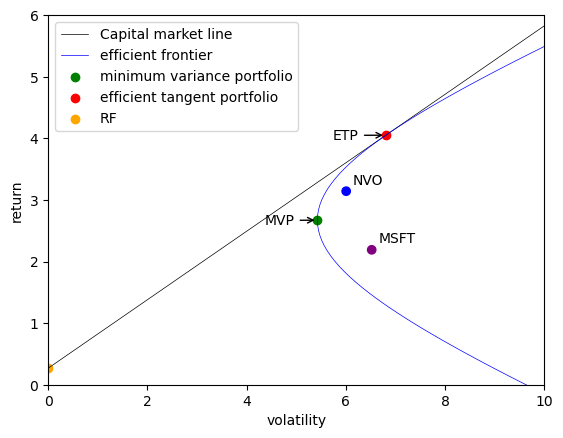

In [53]:
plot_capm(mvp, etp, lin_vec)

Here we have plotted the efficient market frontier with the 3 stocks, the MVP and the ETP. We see as expected, that the minimum variance portfolio is the portfolio which the lowest volatility and that the ETP is exactly tangential with the efficient frontier and the risk-free return. 